In [246]:
 import pandas as pd
import numpy as np
import requests
import json
import re
import matplotlib.pyplot as plt
import warnings

# Gathering Data

In [426]:
# Given file
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [427]:
#Download file using Requests library and URL
response= requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open('image_prediction.tsv',mode='wb')as file:
    file.write(response.content)
    
# Import the tweet image predictions TSV file into a DataFrame
image_pre_df = pd.read_csv('image-predictions.tsv', sep='\t')

In [428]:
# Gather data from twitter API using Python's Tweepy library and store data

import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

ModuleNotFoundError: No module named 'tweepy'

In [ ]:
# List of dictionaries to read tweet's JSON data line by line and later convert to a DataFrame
df_list = []
with open('tweet-json.txt', 'r') as json_file:
    for line in json_file:
        status = json.loads(line)
        
        # Append to list of dictionaries
        df_list.append({'tweet_id': status['id'],
                        'retweet_count': status['retweet_count'],
                        'favorite_count': status['favorite_count'],
                       })

# Create a DataFrame with tweet ID, retweet count, favorite count and display_text_range
json_df= pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

# Assess Data

In [ ]:
# View first 10 rows of twitter_archive DataFrame
twitter_archive.head(10)

In [ ]:
# View last 10 rows of twitter_archive DataFrame
twitter_archive.tail(10)

In [ ]:
twitter_archive.info()

In [ ]:
# View the source values
twitter_archive.source.value_counts()

In [ ]:
#print the rating_numerator values to check if there are incorrect values (negative number or less than 10) 
twitter_archive.rating_numerator.value_counts()

In [ ]:
#print the rating_denominator values to check if there are incorrect values (unequal to 10)
twitter_archive.rating_denominator.value_counts()

In [ ]:
#I observed incorrect values for name like 'a','an' and 'the'  
twitter_archive.name.value_counts()

In [ ]:
image_pre_df.info()
image_pre_df.head(10)

In [429]:
# Check if there are any tweets with no images
len(twitter_archive.tweet_id)- np.in1d(twitter_archive.tweet_id, image_pre_df.tweet_id).astype('int').sum()

281

In [430]:
json_df.info()
json_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


## Quality issues: 
**1- In tweeter_archive dataset, incorrect data type and values for in_reply_to_status_id and in_reply_to_status_id.**

**2- In tweeter_archive dataset, incorrect data type for the timestamp.**

**3- In tweeter_archive dataset, source is difficult to read. So change the source to more readable content.**

**4- In tweeter_archive dataset, remove retweets.**

**5- In tweeter_archive dataset, incorrect values for the rating_numerator it has to be more than 10.**

**6- In tweeter_archive dataset,  incorrect values for the rating_denominator it has to be equal 10.**

**7- In tweeter_archive dataset, incorrect dog names (a, an, such, the, etc.)**

**8- In tweeter_archive dataset, wrong represented of nulls value as None.**

**9- There are many tweets with no images, and we only care about ratings with images.**

**10- In tweeter_archive dataset, there are many dogs have more than one name.**

## Tidiness issues:
**1- In tweeter_archive dataset, remove retweets because it duplicates. and we only care about original ratings. So the other retweets columns are not useful.**

**2- In tweeter_archive dataset, the doggo, floofer, pupper, puppo  columns show one variable. So it should be merged into one column called stage.**

**3- retweet_count and favorite_count columns from json_df should be part of the tweeter_archive dataset.**




# Clean Data



In [431]:
# Take copies of datasets to perform the cleaning step 
twitter_clean = twitter_archive.copy()
image_clean= image_pre_df.copy()
json_clean= json_df.copy()

### Quality Issue:
**1- In tweeter_archive dataset, incorrect data type and values for in_reply_to_status_id and in_reply_to_status_id.**

### Define:
Convert data type for in_reply_to_status_id and in_reply_to_status_id from float to integer by first replace NaN to 0s and then convert it to integer.
### code:

In [432]:
# Replace all NaN elements with 0s
twitter_clean.in_reply_to_status_id = twitter_clean.in_reply_to_status_id.fillna(0)
# Now convert it into 'int64' type 
twitter_clean.in_reply_to_status_id = twitter_clean.in_reply_to_status_id.astype(np.int64)


In [433]:
# Replace all NaN elements with 0s
twitter_clean.in_reply_to_user_id = twitter_clean.in_reply_to_user_id.fillna(0)
# Now convert it into 'int64' type 
twitter_clean.in_reply_to_user_id = twitter_clean.in_reply_to_user_id.astype(np.int64)

### Test

In [434]:
# Now the data type for in_reply_to_status_id and in_reply_to_user_id is integer
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         2356 non-null int64
in_reply_to_user_id           2356 non-null int64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(2), int64(5), ob

### Quality Issue:
**2- In tweeter_archive dataset, incorrect data type for the timestamp.**

### Define:
Convert data type for timestamp to datetime.

### code:

In [435]:
# Change timestamp to datetime
twitter_clean.timestamp = pd.to_datetime(twitter_clean.timestamp)

### Test

In [436]:
# Now the data type for timestamp is datetime 
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         2356 non-null int64
in_reply_to_user_id           2356 non-null int64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1

### Quality Issue:
**3- In tweeter_archive dataset, source is difficult to read. So change the source to more readable content.**

### Define:
Replace the tag and URL to four readable source.

### code:

In [437]:
# Remove tags and URL from sources and replace it with readable source
twitter_clean.source = twitter_clean.source.str.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'Twitter for iPhone')
twitter_clean.source = twitter_clean.source.str.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>', 'Vine')
twitter_clean.source = twitter_clean.source.str.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'Twitter Web Client')
twitter_clean.source = twitter_clean.source.str.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', 'TweetDeck')

### Test

In [438]:
twitter_clean.source.value_counts()

Twitter for iPhone    2221
Vine                    91
Twitter Web Client      33
TweetDeck               11
Name: source, dtype: int64

### Quality Issue:
**4- In tweeter_archive dataset, remove retweets.**

### Define:
Remove the retweets by select only the records where 'retweeted_status_id' is null.

### code:


In [439]:
# Select rows where 'retweeted_status_id' is null
twitter_clean = twitter_clean[twitter_clean.retweeted_status_id.isnull()]

### Test

In [440]:
twitter_clean.query('retweeted_status_id == "NaN"').count()['retweeted_status_id']

0

### Tidiness Issue:
**1- In tweeter_archive dataset, remove retweets columns. we only care about original ratings. So the other retweets columns are not useful.**

### Define:
Drop all retweets columns.

### code:

In [441]:
# Drop retweets columns  
columns = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']
twitter_clean.drop(columns, axis=1, inplace=True)

### Test

In [442]:
# Now there is no columns related to retweets
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    2175 non-null int64
in_reply_to_user_id      2175 non-null int64
timestamp                2175 non-null datetime64[ns]
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dtypes: datetime64[ns](1), int64(5), object(8)
memory usage: 254.9+ KB


### Quality Issue:
**5- In tweeter_archive dataset, incorrect values for the rating_numerator it has to be more than 10.**

### Define:
Remove all rows which have rating_numerator <10 to keep only rows that has numerator more than or equal to 10.

### code:

In [443]:
# Drop rows which have rating_numerator <10 
twitter_clean= twitter_clean[twitter_clean.rating_numerator >= 10]

### Test

In [444]:
twitter_clean.rating_numerator.value_counts().sort_index()

10      442
11      426
12      500
13      307
14       43
15        1
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        1
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

### Quality Issue:
**6- In tweeter_archive dataset,  incorrect values for the rating_denominator it has to be equal 10.**

### Define:
Remove all rows which have rating_denominator not equal to 10 to keep only rows that have denominator equal to 10.

### code:

In [445]:
# Drop 17 rows which have rating_denominator != 10
twitter_clean= twitter_clean[twitter_clean.rating_denominator == 10]

### Test

In [446]:
twitter_clean.rating_denominator.value_counts()

10    1727
Name: rating_denominator, dtype: int64

### Quality Issue:
**7- In tweeter_archive dataset, incorrect dog names (a, an, such, the, etc.)**

### Define:
Replace all lowercase values of name column with None to remove the (a, an, such, the, etc.)

### code:

In [447]:
# Replace all lowercase values of name column with None
twitter_clean.name[twitter_clean.name.str.islower()] = 'None'

### Test

In [448]:
 twitter_clean.name.value_counts()

None         592
Charlie       11
Lucy          10
Cooper         9
Oliver         9
Tucker         8
Winston        7
Sadie          7
Penny          7
Bo             6
Koda           6
Daisy          6
Lola           6
Stanley        5
Bentley        5
Oscar          5
Bailey         5
Toby           5
Jax            5
Milo           5
Louis          5
Leo            5
Jeffrey        4
Scooter        4
Sammy          4
Scout          4
Duke           4
Bella          4
Rusty          4
Winnie         4
            ... 
Geoff          1
Barney         1
Crumpet        1
Rumpole        1
Stu            1
Ralphie        1
Brandi         1
Harper         1
Tripp          1
Emmy           1
Ralphé         1
Jebberson      1
Huck           1
Alfy           1
Ferg           1
Ken            1
Snicku         1
Liam           1
Malikai        1
Tupawc         1
Striker        1
Mattie         1
Dawn           1
Pickles        1
Koko           1
Bronte         1
Tobi           1
Storkson      

### Quality Issue:
**8- In tweeter_archive dataset, wrong represented of nulls value as None.**

### Define:
Replace all None in 'doggo','floofer','pupper'and 'puppo' culomns with NaN.

### code:

In [449]:
# Replace None with NaN
twitter_clean.doggo= twitter_clean.doggo.replace('None',np.nan)
twitter_clean.floofer= twitter_clean.floofer.replace('None',np.nan)
twitter_clean.pupper= twitter_clean.pupper.replace('None',np.nan)
twitter_clean.puppo= twitter_clean.puppo.replace('None',np.nan)

### Test

In [450]:
twitter_clean.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,0,0,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,0,0,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,0,0,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,0,0,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,0,0,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN
5,891087950875897856,0,0,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,NaN,NaN,NaN,NaN
6,890971913173991426,0,0,2017-07-28 16:27:12,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN,NaN,NaN,NaN
7,890729181411237888,0,0,2017-07-28 00:22:40,Twitter for iPhone,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,NaN,NaN,NaN,NaN
8,890609185150312448,0,0,2017-07-27 16:25:51,Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,NaN,NaN,NaN
9,890240255349198849,0,0,2017-07-26 15:59:51,Twitter for iPhone,This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,NaN,NaN,NaN


### Quality Issue:
**9- There are many tweets with no images, and we only care about ratings with images.**

### Define:
Drop the rows in twitter_clean which don't have dog image.

### code:

In [451]:
# Drop the rows in twitter_clean which don't have dog image
twitter_clean = twitter_clean[twitter_clean.tweet_id.isin(image_clean.tweet_id)]

### Test

In [452]:
twitter_clean[~twitter_clean.tweet_id.isin(image_clean.tweet_id)].count()['tweet_id']

0

### Quality Issue:
**10- In tweeter_archive dataset, there are many dogs have more than one name.**

### Define:
For those dogs which has more than one name, I'll separate between these names by a comma.


### Tidiness Issue:
**2- In tweeter_archive dataset, the doggo, floofer, pupper, puppo  columns show one variable. So it should be merged into one column called stage.**

### Define:
Merge the doggo, floofer, pupper, puppo columns and put them in a new column called 'stage' and then drop these 4 columns.


**I'll solve both of them together**
### code:

In [453]:
# If the dog has more than one name I'll separate between them by comma and put them in a new column called 'stage'
twitter_clean['stage']= twitter_clean.doggo.str.cat([twitter_clean.floofer,twitter_clean.pupper,twitter_clean.puppo],sep=',',na_rep='Null')
twitter_clean.stage= twitter_clean.stage.str.replace('doggo,Null,Null,Null','doggo')
twitter_clean.stage= twitter_clean.stage.str.replace('Null,floofer,Null,Null','floofer')
twitter_clean.stage= twitter_clean.stage.str.replace('Null,Null,pupper,Null','pupper')
twitter_clean.stage= twitter_clean.stage.str.replace('Null,Null,Null,puppo','puppo')
twitter_clean.stage= twitter_clean.stage.str.replace('doggo,Null,pupper,Null','doggo,pupper')
twitter_clean.stage= twitter_clean.stage.str.replace('Null,Null,Null,Null','NaN')

In [454]:
# Then drop 'doggo','floofer','pupper','puppo' columns
twitter_clean= twitter_clean.drop(['doggo','floofer','pupper','puppo'],axis=1)

### Test

In [455]:
twitter_clean.info()
twitter_clean.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566 entries, 0 to 2350
Data columns (total 11 columns):
tweet_id                 1566 non-null int64
in_reply_to_status_id    1566 non-null int64
in_reply_to_user_id      1566 non-null int64
timestamp                1566 non-null datetime64[ns]
source                   1566 non-null object
text                     1566 non-null object
expanded_urls            1566 non-null object
rating_numerator         1566 non-null int64
rating_denominator       1566 non-null int64
name                     1566 non-null object
stage                    1566 non-null object
dtypes: datetime64[ns](1), int64(5), object(5)
memory usage: 146.8+ KB


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,0,0,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,0,0,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,0,0,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,0,0,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,0,0,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN
5,891087950875897856,0,0,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,NaN
6,890971913173991426,0,0,2017-07-28 16:27:12,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN
7,890729181411237888,0,0,2017-07-28 00:22:40,Twitter for iPhone,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,NaN
8,890609185150312448,0,0,2017-07-27 16:25:51,Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN
9,890240255349198849,0,0,2017-07-26 15:59:51,Twitter for iPhone,This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo


### Tidiness Issue:
**3- retweet_count and favorite_count columns from json_df should be part of the tweeter_archive dataset.**

### Define:
Join twitter_clean with json_clean by tweet_id to make twitter_clean data set have retweet & favorite columns.


### code:

In [456]:
# Join both twitter_clean with json_clean
twitter_clean = twitter_clean.merge(json_clean, on='tweet_id', how='inner') 

### Test

In [457]:
twitter_clean.info()
twitter_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566 entries, 0 to 1565
Data columns (total 13 columns):
tweet_id                 1566 non-null int64
in_reply_to_status_id    1566 non-null int64
in_reply_to_user_id      1566 non-null int64
timestamp                1566 non-null datetime64[ns]
source                   1566 non-null object
text                     1566 non-null object
expanded_urls            1566 non-null object
rating_numerator         1566 non-null int64
rating_denominator       1566 non-null int64
name                     1566 non-null object
stage                    1566 non-null object
retweet_count            1566 non-null int64
favorite_count           1566 non-null int64
dtypes: datetime64[ns](1), int64(7), object(5)
memory usage: 171.3+ KB


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count
0,892420643555336193,0,0,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,8853,39467
1,892177421306343426,0,0,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,6514,33819
2,891815181378084864,0,0,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,4328,25461
3,891689557279858688,0,0,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,8964,42908
4,891327558926688256,0,0,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,9774,41048



# Store Data



In [417]:
#Store the twitter_clean in a CSV file named twitter_archive_master.csv
twitter_clean.to_csv('twitter_archive_master.csv', index=False)

# Analyze  Data

In [418]:
# Create a copy of twitter_archive_clean
df = twitter_clean.copy()

In [419]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566 entries, 0 to 1565
Data columns (total 13 columns):
tweet_id                 1566 non-null int64
in_reply_to_status_id    1566 non-null int64
in_reply_to_user_id      1566 non-null int64
timestamp                1566 non-null datetime64[ns]
source                   1566 non-null object
text                     1566 non-null object
expanded_urls            1566 non-null object
rating_numerator         1566 non-null int64
rating_denominator       1566 non-null int64
name                     1566 non-null object
stage                    1566 non-null object
retweet_count            1566 non-null int64
favorite_count           1566 non-null int64
dtypes: datetime64[ns](1), int64(7), object(5)
memory usage: 171.3+ KB


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count
0,892420643555336193,0,0,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,8853,39467
1,892177421306343426,0,0,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,6514,33819
2,891815181378084864,0,0,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,4328,25461
3,891689557279858688,0,0,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,8964,42908
4,891327558926688256,0,0,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,9774,41048


### 1- The most common Twitter source used

In [420]:
df['source'].value_counts()

Twitter for iPhone    1539
Twitter Web Client      17
TweetDeck               10
Name: source, dtype: int64

So here we can see that the most common Twitter source used is Twitter for iPhone

### 2- The highest dog rating

In [421]:
df['rating_numerator'].value_counts().sort_index()

10      419
11      396
12      450
13      261
14       35
26        1
27        1
75        1
420       1
1776      1
Name: rating_numerator, dtype: int64

In [422]:
df.query("rating_numerator ==1776")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count
704,749981277374128128,0,0,2016-07-04 15:00:45,TweetDeck,This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,NaN,2772,5569


so the highest dog rating have 1776/10 called Atticus

### 3-The highest retweet of dog stage

In [423]:
df['stage'][df['retweet_count']].value_counts()

NaN             612
pupper           79
doggo            29
puppo             9
floofer           3
doggo,pupper      2
Name: stage, dtype: int64

The dog stage that has the highest retweet is pupper

### 4-The highest favorite of dog stage

In [424]:
df['stage'][df['favorite_count']].value_counts()

NaN             191
pupper           28
doggo             9
puppo             2
doggo,pupper      1
floofer           1
Name: stage, dtype: int64

The dog stage that has the highest favorite is pupper

# Visualize Data

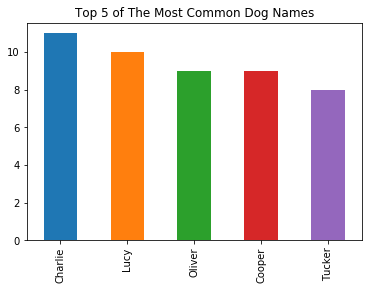

In [425]:
df.name.value_counts()[1:6].plot('bar',title="Top 5 of The Most Common Dog Names");

**In conclusion, we can see that the most common dog names are Charlie, Lucy, Oliver, Cooper and Tucker.**